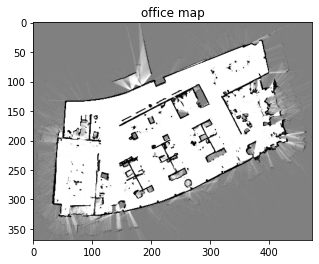

In [1]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('osrc_paper_windows.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.title('office map')
plt.show()

In [2]:
img.shape

(369, 473, 3)

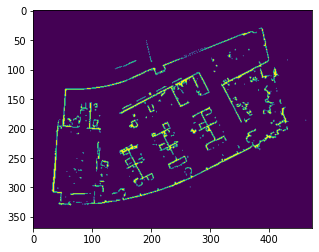

In [3]:
import numpy as np
res = cv2.inRange(img,np.array([0,0,0]),np.array([30,30,30]))
#res = res*100.0

kernel = np.ones((5,5),np.uint8)
#res = cv2.dilate(res, kernel)
#res = cv2.erode(res, kernel)
#res = cv2.dilate(res, kernel)
plt.imshow(res)
plt.show()

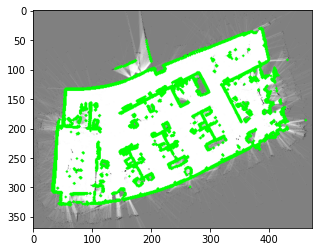

In [4]:
contours, hierarchy = cv2.findContours(res*100, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_con = img.copy()
cv2.drawContours(img_con, contours, -1, (0,255,0), 3)
plt.imshow(img_con)
plt.show()

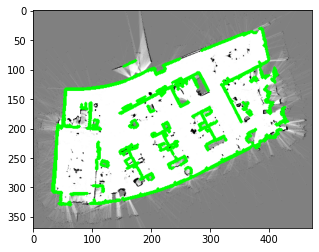

In [5]:
filtered_cont = []
for contour in contours:
    if cv2.arcLength(contour, False) < 30:
        continue
    filtered_cont.append(contour)
img_con = img.copy()
cv2.drawContours(img_con, filtered_cont, -1, (0,255,0), 3)
plt.imshow(img_con)
plt.show()

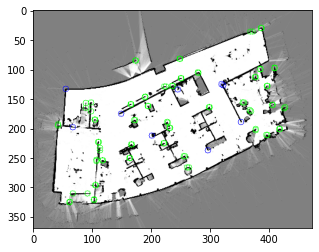

In [35]:
img_keypoints = img.copy()
for contour in filtered_cont:
    prev_pt = None
    prev_prev_pt = None
    counter = 0
    simplified_cont =  cv2.approxPolyDP(contour, 30, False)
    for pt in simplified_cont:
        if prev_pt is None:
            cv2.circle(img_keypoints, (pt[0][0], pt[0][1]), 5, (255,0,0), 1)
        elif counter == len(simplified_cont) - 1:
            cv2.circle(img_keypoints, (pt[0][0], pt[0][1]), 5, (0,255,0), 1)
        elif prev_prev_pt is not None:      
            vec1 = prev_pt - prev_prev_pt
            vec2 = pt[0] - prev_pt
            angle = np.arccos(vec1.dot(vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2)))
            if abs(angle) > 1.4:
                cv2.circle(img_keypoints, (prev_pt[0], prev_pt[1]), 5, (0, 0, 255), 1)
        prev_prev_pt = prev_pt
        prev_pt = pt[0]
        counter += 1
    cv2.circle(img_keypoints, (contour[-1][0][0], contour[-1][0][1]), 5, (0,255,0), 1)
    cv2.circle(img_keypoints, (contour[0][0][0], contour[0][0][1]), 5, (0,255,0), 1)
plt.imshow(img_keypoints)
plt.show()

In [4]:
res.shape

(369, 473)

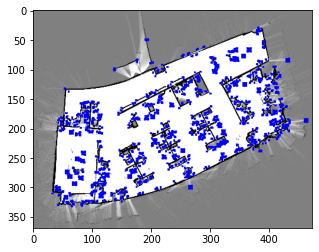

In [5]:
dst = cv2.cornerHarris(res*100,2,5,0.04)
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img_corner = img.copy()
img_corner[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(img_corner)
plt.show()

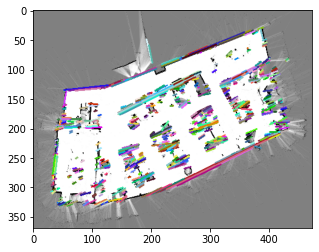

In [79]:
from random import random
minLineLength = 10
maxLineGap = 1
lines = cv2.HoughLinesP(res*100,1,np.pi/45,100,minLineLength,maxLineGap)
img2 = img.copy()
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(img2,(x1,y1),(x2,y2),(255*random(),255*random(),255*random()),2)

plt.imshow(img2)
plt.show()

In [80]:
def determine_line_intersects_and_angle(line1, line2):
    x1_1, y1_1, x1_2, y1_2 = line1[0]
    x2_1, y2_1, x2_2, y2_2 = line2[0]
    
    gradient1 = np.array([x1_1, y1_1]) - np.array([x1_2, y1_2])
    gradient2 = np.array([x2_1, y2_1]) - np.array([x2_2, y2_2])
    
    D = (x1_1 - x1_2)*(y2_1 - y2_2) - (y1_1-y1_2)*(x2_2)
    
    if D == 0:
        return None
    
    px = ((x1_1*y1_2 - y1_1*x1_2)*(x2_1-x2_2) - (x1_1 - x1_2)*(x2_1*y2_2 - y2_1*x2_2))/D
    py = ((x1_1*y1_2 - y1_1*x1_2)*(y2_1-y2_2) - (y1_1 - y1_2)*(x2_1*y2_2 - y2_1*x2_2))/D
    
    angle = np.arccos(gradient1.dot(gradient2)/(np.linalg.norm(gradient1) * np.linalg.norm(gradient2)))
    
    return (px, py, angle)

In [81]:
determine_line_intersects_and_angle([[0, -1, 0, 1]], [[1, 0, -1, 0]])

(-0.0, -0.0, 1.5707963267948966)

In [82]:
determine_line_intersects_and_angle([[1, -1, -1, 1]], [[1, 0, -1, 0]])

(-0.0, -0.0, 0.7853981633974484)

In [15]:
def line_segment_intersection(line, point):
    x1_1, y1_1, x1_2, y1_2 = line[0]
    start_pt = np.array([x1_1, y1_1])
    end_pt = np.array([x1_2, y1_2])
    grad1 = point - start_pt
    grad2 = end_pt - start_pt
    return grad2.dot(grad1) > 0 and np.linalg.norm(grad2) > np.linalg.norm(grad1)

line_segment_intersection([[1,1,0,0]], [0.5,0.5])

True

In [16]:
line_segment_intersection([[1,1,0,0]], [-0.5,-0.5])

False

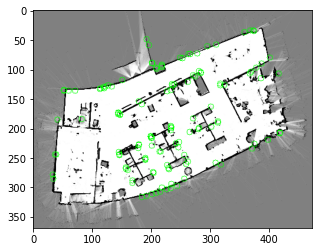

In [84]:
img2 = img.copy()

lidar_end_points = []
#line = 
for line1 in lines:
    x1, y1, x2, y2 = line1[0]
    length = np.linalg.norm(np.array([x1,y1]) - np.array([x2,y2]))
    if length < 30:
        continue
    cv2.circle(img2, (int(x1),int(y1)), 5, (0,255,0), 1)
    cv2.circle(img2, (int(x2),int(y2)), 5, (0,255,0), 1)
    lidar_end_points.append((x1,y1))
    lidar_end_points.append((x2,y2))
    
lidar_end_points = np.array(lidar_end_points)
plt.imshow(img2)
plt.show()

In [74]:
import yaml

file = open("office.building.yaml")
office_map = yaml.load(file)

vertices = office_map["levels"]["L1"]["vertices"]

verts = np.array([[vertex[0], vertex[1]] for vertex in vertices])

walls = office_map["levels"]["L1"]["walls"]

measurements = office_map["levels"]["L1"]["measurements"]

wall_vertex_indices = set([wall[0] for wall in walls] + [wall[1] for wall in walls])

wall_verts = verts[list(wall_vertex_indices)]

<ipython-input-74-087b58f30282>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  office_map = yaml.load(file)


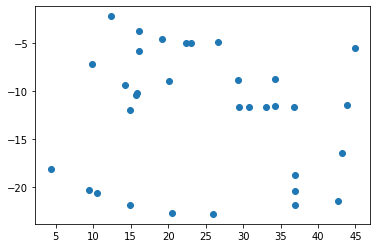

In [85]:
dx = np.array(wall_verts[measurements[0][0]]) - np.array(wall_verts[measurements[0][1]])
norm = measurements[0][2]["distance"][-1]
pixel_norm = np.linalg.norm(dx)
scale = norm/pixel_norm
verts_transformed = np.array([[v[0]*scale, -v[1]*scale] for v in wall_verts])
plt.scatter(verts_transformed[:,0], verts_transformed[:,1])
plt.show()

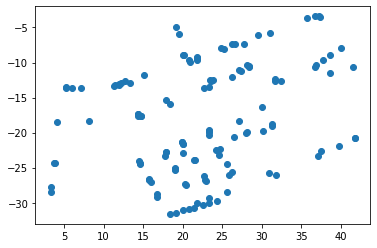

In [86]:
plt.scatter(lidar_end_points[:,0]/10, -lidar_end_points[:,1]/10)
plt.show()